# Imports

In [1]:
# Standard library imports
import os
import copy
import math
import glob
import random
import zipfile
import functools
from functools import partial

# Third-party libraries
import albumentations as A
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from tqdm import auto, tqdm

# PyTorch imports
from torch import einsum, nn, optim
from torch.autograd import Variable
from torch.nn import Module, ModuleList, functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.fft import fft2, ifft2
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, utils
from torchvision.datasets import MNIST
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Config

In [3]:
# Random seed for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and environment configurations
DATASET_PARENT_DIR = '../dataset/' # Change this to your desired directory
DATASET_API_URI = 'mateuszbuda/lgg-mri-segmentation'
DATASET_DIR = f'{DATASET_PARENT_DIR}kaggle_3m/'

# Image and batch processing configurations
IMAGE_HEIGHT = 32
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
TEST_SIZE = 0.1

# Training configurations
NUM_EPOCHS = 50
LEARNING_RATE = 2e-4
TIMESTEPS = 100
NOISE_SCHEDULE = 'cosine'

# Learning rate scheduler configurations
REDUCE_LR_FACTOR = 0.5
REDUCE_LR_PATIENCE = 3

# Visualization and model saving configurations
VISUALIZATION_SAMPLE_INTERVAL = 5
VISUALIZATION_NUM_SAMPLES = 3
MODEL_SAVE_DIR = "models/"
MODEL_SAVE_PATH_TEMPLATE = MODEL_SAVE_DIR + 'best_diffusion_model_epoch_{}.pth'

if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

In [4]:
print(f'Using device: {device}')

Using device: cuda


# Utility Functions

In [5]:
def device_grad_decorator(device=None, no_grad=False):
    """
    A decorator to handle PyTorch tensor device allocation and gradient computation.

    Args:
        device (str or torch.device, optional): The device to which all tensor arguments should be moved.
                                                Examples: 'cpu', 'cuda', torch.device('cuda').
        no_grad (bool, optional): If True, the function will be executed within a torch.no_grad() context, 
                                  disabling gradient calculations. Defaults to False.

    Returns:
        Callable: A decorated function with tensor arguments moved to the specified device and
                  optionally executed without gradient tracking.

    Usage:
        @device_grad_decorator(device='cuda', no_grad=True)
        def some_function(tensor):
            ...
    """
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # Move positional tensor arguments to the specified device
            if device:
                args = tuple(
                    arg.to(device) if isinstance(arg, torch.Tensor) else arg 
                    for arg in args
                )
                # Move keyword tensor arguments to the specified device
                kwargs = {
                    k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                    for k, v in kwargs.items()
                }
            # Execute the function in no_grad context if specified
            if no_grad:
                with torch.no_grad():
                    return func(*args, **kwargs)
            return func(*args, **kwargs)

        return wrapper
    return decorator

def visualize_img(ax, img, title, is_mask=False):
    """
    Displays an image on the given matplotlib axis with an optional grayscale colormap.

    Args:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis on which to display the image.
        img (numpy.ndarray): The image data to be displayed.
        title (str): The title for the image.
        is_mask (bool, optional): If True, display the image in grayscale. Defaults to False.
    """
    ax.set_title(title)
    ax.imshow(img, cmap='gray' if is_mask else None)
    ax.axis('off')


# Data

## Download LGG Segmentation Dataset

This dataset is utilized in several significant research studies, including:

1. Mateusz Buda, Ashirbani Saha, Maciej A. Mazurowski. <i>"Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm."</i> Published in Computers in Biology and Medicine, 2019.

2. Maciej A. Mazurowski, Kal Clark, Nicholas M. Czarnek, Parisa Shamsesfandabadi, Katherine B. Peters, Ashirbani Saha. <i>"Radiogenomics of lower-grade glioma: algorithmically-assessed tumor shape is associated with tumor genomic subtypes and patient outcomes in a multi-institutional study with The Cancer Genome Atlas data."</i> Featured in the Journal of Neuro-Oncology, 2017.

The dataset comprises brain magnetic resonance (MR) images accompanied by manual FLAIR (Fluid-Attenuated Inversion Recovery) abnormality segmentation masks. These images are sourced from The Cancer Imaging Archive (TCIA) and are specifically selected from 110 patients within The Cancer Genome Atlas (TCGA) lower-grade glioma collection. Each patient's dataset includes a FLAIR sequence along with available genomic cluster data.

Key dataset features:
- **Image Source**: The Cancer Imaging Archive (TCIA)
- **Patient Count**: 110 (from TCGA lower-grade glioma collection)
- **Content**: Brain MR Images with FLAIR sequence
- **Additional Data**: Tumor genomic clusters and patient data (available in `data.csv` file)

Dataset Download Source: [Kaggle - LGG MRI Segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

In [6]:
if not os.path.exists(DATASET_DIR):
    from kaggle.api.kaggle_api_extended import KaggleApi
    
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET_API_URI, path=DATASET_PARENT_DIR,  unzip=True)
else:
    print(f"Data already exists at {DATASET_DIR}")

Data already exists at ../dataset/kaggle_3m/


In [7]:
! tree {DATASET_DIR} -L 4 | head -n 11

../dataset/kaggle_3m/
├── data.csv
├── README.md
├── TCGA_CS_4941_19960909
│   ├── TCGA_CS_4941_19960909_10_mask.tif
│   ├── TCGA_CS_4941_19960909_10.tif
│   ├── TCGA_CS_4941_19960909_11_mask.tif
│   ├── TCGA_CS_4941_19960909_11.tif
│   ├── TCGA_CS_4941_19960909_12_mask.tif
│   ├── TCGA_CS_4941_19960909_12.tif
│   ├── TCGA_CS_4941_19960909_13_mask.tif


## Prepare Labels

This dataset contains brain MRI images and manual FLAIR abnormality segmentation masks, where each pixel value of masks indicates the presence or absence of cancer (0 and 1, respectively). The images correspond to 110 patients whose IDs are available in the patient_ids.csv file.


In [8]:
def pos_neg_diagnosis(mask_path):
    """
    Determines whether a mask image indicates the presence of cancer.

    Args:
        mask_path (str): Path to the mask image file.

    Returns:
        int: 1 if the mask contains positive values (cancer detected), 0 otherwise.
    """
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            raise ValueError(f"Failed to load image at path: {mask_path}")
        return int(np.max(mask) > 0)
    except Exception as e:
        raise RuntimeError(f"Error processing mask at {mask_path}: {e}")

def load_mri_df(mri_scans_path):
    """
    Loads MRI scan data into a DataFrame, including cancer diagnosis based on mask files.

    Args:
        mri_scans_path (str): Path to the root directory containing subdirectories of MRI scans.

    Returns:
        pd.DataFrame: A DataFrame with columns:
                      - 'patient_id': Patient identifier derived from subdirectory names.
                      - 'image_path': Path to the MRI image files.
                      - 'mask_path': Path to the corresponding mask image files.
                      - 'has_cancer': 1 if the mask indicates cancer, 0 otherwise.
    """
    data_records = []
    
    # Iterate through subdirectories
    for sub_dir_path in glob.glob(os.path.join(mri_scans_path, "*/")):
        dir_name = os.path.basename(os.path.normpath(sub_dir_path))
        
        try:
            # Collect image and mask files
            image_files = [f for f in os.listdir(sub_dir_path) if not f.endswith('mask.tif')]
            mask_files = [f for f in os.listdir(sub_dir_path) if f.endswith('mask.tif')]
            
            # Match image and mask pairs
            for image_file, mask_file in zip(sorted(image_files), sorted(mask_files)):
                image_path = os.path.join(sub_dir_path, image_file)
                mask_path = os.path.join(sub_dir_path, mask_file)
                data_records.append([dir_name, image_path, mask_path])
        except Exception as e:
            # Log the specific directory that caused an issue
            print(f"Error processing directory '{sub_dir_path}': {e}")

    # Create a DataFrame and compute cancer diagnosis
    mri_df = pd.DataFrame(data_records, columns=['patient_id', 'image_path', 'mask_path'])
    mri_df['has_cancer'] = mri_df['mask_path'].apply(pos_neg_diagnosis)
    
    return mri_df

In [9]:
mri_df = load_mri_df(mri_scans_path=DATASET_DIR)
mri_df.head()

,patient_id,image_path,mask_path,has_cancer
0,TCGA_HT_A5RC_19990831,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,0
1,TCGA_HT_A5RC_19990831,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,0
2,TCGA_HT_A5RC_19990831,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,0
3,TCGA_HT_A5RC_19990831,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,0
4,TCGA_HT_A5RC_19990831,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,../dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCG...,0


## Explatory Data Analysis (EDA)

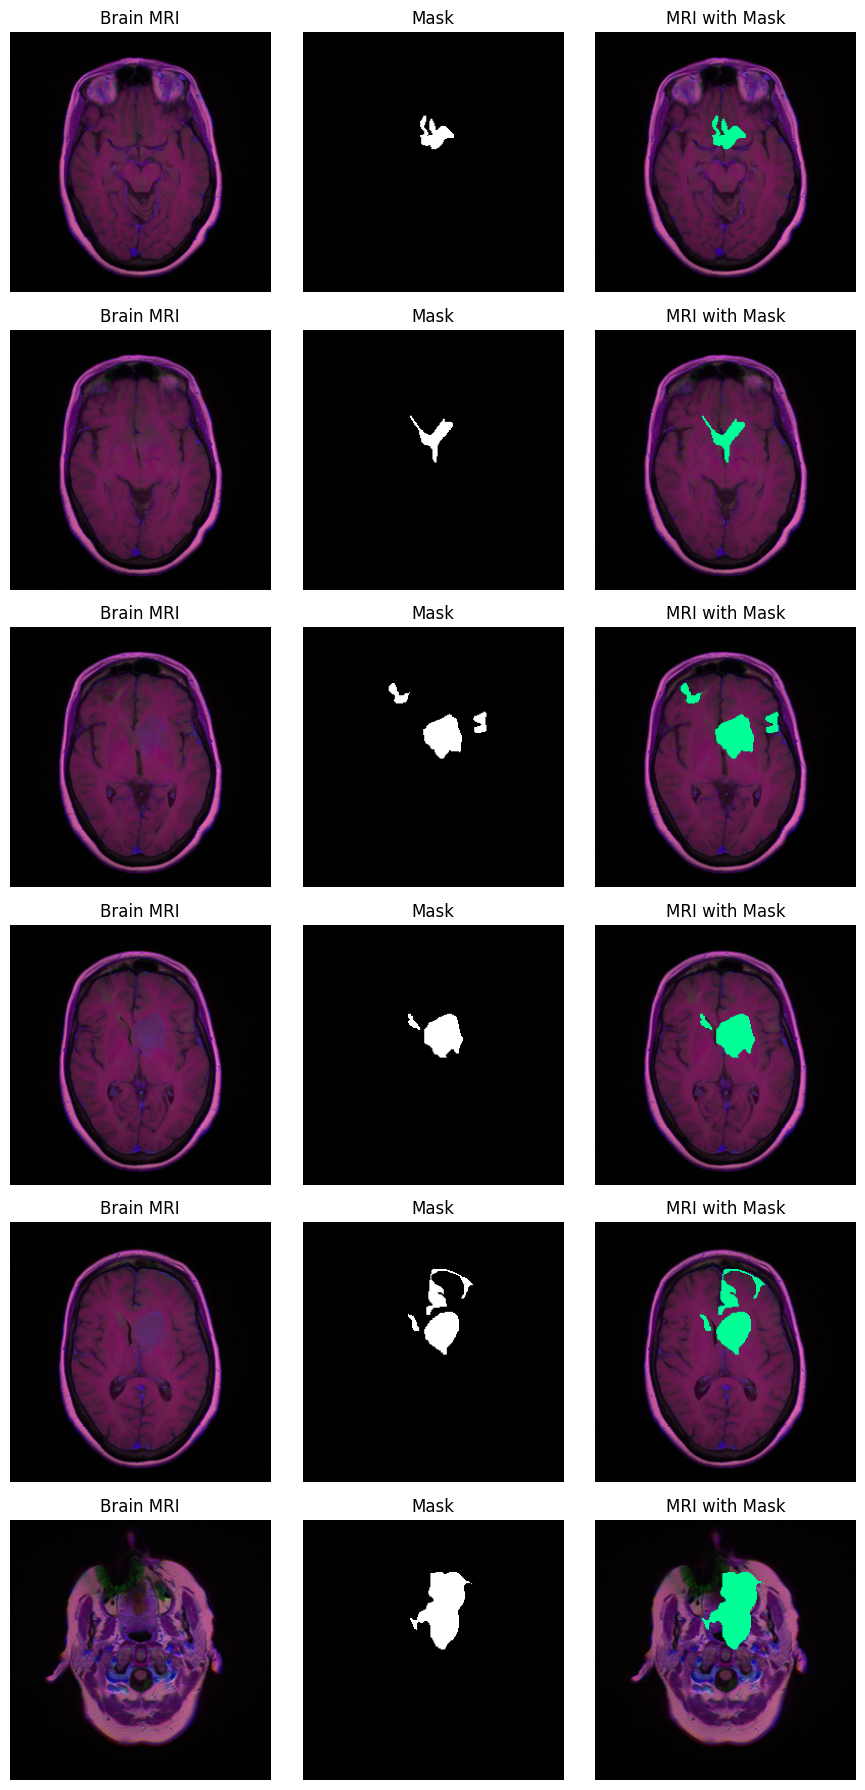

In [10]:
def process_and_visualize_cases(mri_df, max_rows, axs):
    """
    Processes and visualizes MRI and mask images for cases with cancer.

    Args:
        mri_df (pd.DataFrame): DataFrame containing MRI image and mask paths, and diagnosis.
        max_rows (int): Maximum number of rows to display in the visualization.
        axs (np.ndarray): Array of matplotlib Axes for displaying the images.

    Returns:
        int: Number of rows visualized.
    """
    row_count = 0

    for idx in mri_df.index:
        try:
            # Check if the current case has cancer
            has_cancer = mri_df.at[idx, 'has_cancer']
            if has_cancer == 1:
                # Load the MRI image and mask
                img_path = mri_df.at[idx, 'image_path']
                mask_path = mri_df.at[idx, 'mask_path']
                img = io.imread(img_path)
                mask = io.imread(mask_path)

                # Visualize the images
                visualize_img(axs[row_count][0], img, 'Brain MRI')
                visualize_img(axs[row_count][1], mask, 'Mask', is_mask=True)

                # Overlay mask on the MRI image
                overlayed_img = img.copy()
                overlayed_img[mask == 255] = (0, 255, 150)
                visualize_img(axs[row_count][2], overlayed_img, 'MRI with Mask')

                # Increment the row count
                row_count += 1

            # Stop when maximum rows are filled
            if row_count == max_rows:
                break

        except Exception as e:
            print(f"Error visualizing row {idx}: {e}")

    fig.tight_layout()
    plt.show()

# Main visualization logic
max_rows = 6
fig, axs = plt.subplots(max_rows, 3, figsize=(9, 3 * max_rows))

# Process and visualize cases
process_and_visualize_cases(mri_df, max_rows, axs)

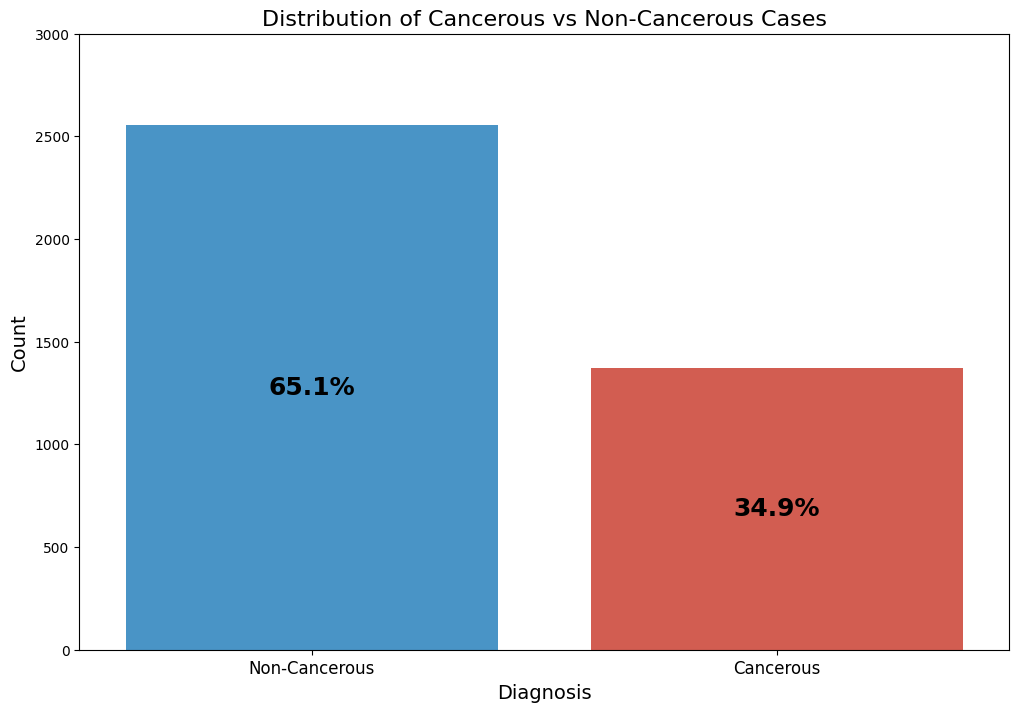

In [11]:
def display_cancerous_rate(mri_df):
    """
    Displays the distribution of cancerous and non-cancerous cases in the dataset.

    Args:
        mri_df (pd.DataFrame): DataFrame containing MRI image and mask paths, and diagnosis.
    """
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(x='has_cancer', data=mri_df, palette=['#3498db', '#e74c3c'])
    plt.title('Distribution of Cancerous vs Non-Cancerous Cases', fontsize=16)
    plt.xlabel('Diagnosis', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    ax.set_xticklabels(['Non-Cancerous', 'Cancerous'], fontsize=12)
    ax.set_ylim(0, 3000)  # Set y-axis height to 3000

    # Calculate percentages
    total = len(mri_df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2
        ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=18, color='black', fontweight='bold')

    plt.show()

# Display the cancerous rate
display_cancerous_rate(mri_df)

# MedSegDiff

Following the standard implementation of Denoising Diffusion Probabilistic Models (DDPMs), a U-Net architecture is employed for learning. To achieve segmentation, the step estimation function ($\epsilon_{\theta}$) is conditioned on the raw image prior, described by:

$$
\epsilon_{\theta}(x_t, I, t) = D((E_{t}^{I} + E_{t}^{x}, t))
$$

where $E_{t}^{I}$ is the conditional feature embedding (the raw image embedding), and $E_{t}^{x}$ is the segmentation map feature embedding at the current step. These components are combined and forwarded to a U-Net decoder $D$ for reconstruction. The step index $t$ is integrated with the embeddings and decoder features, leveraging a shared learned lookup table.

<p style="text-align: center;">
  <img src="https://raw.githubusercontent.com/deepmancer/medseg-diffusion/main/images/model_overview.png" style="display: block; margin: auto;" width="800"/>
</p>


The loss of our model is represented by the following equation: $\mathcal{L} = \mathbb{E}_{mask_0,\epsilon,t}[\lVert \epsilon - \epsilon_\theta(\sqrt{\bar{a}_t}mask_0 + \sqrt{1 - \bar{a}_t}\epsilon, I_i,t) \rVert^2]$


In each iteration, a random pair of raw image $I_i$ and segmentation label $mask_i$ are sampled for training. The iteration number is sampled from a uniform distribution and $\epsilon$ from a Gaussian distribution. The main architecture of the model is a modified ResUNet, which we implement with a ResNet encoder followed by a UNet decoder. $I$ and $x_t$ (noisy mask at the step=$t$) are encoded with two individual encoders.



## Review Denoising Diffusion Probabilistic Models (DDPMs)

In this notebook, we will implement a **Denoising Diffusion Probabilistic Model (DDPM)** for brain tumor segmentation on MRI images. Diffusion models are generative models consisting of two main stages: **Forward Diffusion** and **Reverse Diffusion**. In the following sections, we will break down these stages.

### 🔄 Forward Diffusion Process

The forward diffusion process transforms a clean segmentation mask into progressively noisier representations. The steps are as follows:

1. **Noise Addition**: 
   - Starting with an original segmentation mask $\text{mask}_0$ sampled from the real data distribution, Gaussian noise is iteratively added at each step $t$ over $T$ steps.
   - The noise is scaled based on a variance schedule $\beta_t$, ensuring controlled perturbation at each step.

2. **Progressive Degradation**:
   - Each step produces a noisier version of the mask, denoted as $\text{mask}_t$, where features gradually become indistinguishable as $t$ increases.
   - This progression creates a sequence $\text{mask}_0, \text{mask}_1, \dots, \text{mask}_T$.

3. **Convergence to Gaussian Noise**:
   - As $T \to \infty$, the segmentation mask $\text{mask}_T$ becomes indistinguishable from an isotropic Gaussian distribution, effectively losing all original information.


<p style="text-align: center;">
  <img src="https://raw.githubusercontent.com/deepmancer/medseg-diffusion/main/images/diff_forward.png" style="display: block; margin: auto;" width="900"/>
</p>

<p style="text-align: center;">
  <img src="https://raw.githubusercontent.com/deepmancer/medseg-diffusion/main/images/diff_forward2.png" style="display: block; margin: auto;" width="650"/>
</p>

### 🔁 Reverse Diffusion Process

The reverse diffusion process reconstructs the original segmentation mask from the noisy data $\text{mask}_T$ by iteratively denoising. The steps are as follows:

1. **Noise Prediction**:
   - A **U-Net architecture** is trained to predict the Gaussian noise $\epsilon_t$ added to the segmentation mask during the forward diffusion process.
   - The model learns a conditional mapping $\epsilon_\theta(\text{mask}_t, t)$, where $\theta$ represents the model parameters.

2. **Stepwise Denoising**:
   - Starting with $\text{mask}_T$, the model iteratively refines the noisy mask by subtracting the predicted noise at each step $t$, moving from $t = T$ to $t = 0$.
   - At each step, the predicted distribution $q(\text{mask}_{t-1} | \text{mask}_t)$ guides the reconstruction process.

3. **Final Reconstruction**:
   - After $T$ reverse steps, the output $\text{mask}_0$ closely approximates the original segmentation mask sampled from the real distribution.
   - This process effectively reverses the effects of forward noise addition, bridging the gap between isotropic Gaussian noise and meaningful segmentation masks.

<p style="text-align: center;">
  <img src="https://raw.githubusercontent.com/deepmancer/medseg-diffusion/main/images/diff_reverse.png" style="display: block; margin: auto;" width="900"/>
</p>

## Architecture Overview

Please find below a description of the components of the U-Net architecture that will be implemented for this task:

### 1) Dynamic Encoding Process

- *FF-Parser Input*: The segmentation map is first input into the Feature Frequency Parser (FF-Parser), which helps to reduce high-frequency noise and refine the feature representation.
- *Attentive Fusion*: After FF-Parser processing, the denoised feature map is combined synergistically with the prior image embeddings. An attentive-like mechanism is employed to enhance regional attention and feature saliency.
- *Iterative Refinement*: The enriched feature map is then subject to iterative refinement through the FF-Parser and the attentive mechanism, culminating at the bottleneck phase.
- *Bottleneck Convergence*: At this point, the processed feature map is added to the UNet encoder's outputs, resulting in an improved segmentation map that proceeds to the final encoding stage.

### 2) Time Encoding Block
- *Sinusoidal Embedding Calculation*: This step begins with the calculation of sinusoidal timestep embeddings.
- *Initial Processing Layers*: These embeddings are then passed through a linear layer, followed by SiLU activation, and another linear layer.
- *Integration into Residual Blocks*: Time features are then integrated into residual blocks. This is achieved either through straightforward spatial addition or via adaptive group normalization.

### 3) Bottleneck Block
- *Embedding Fusion*: At the core of the U-Net, this phase combines the embeddings from the UNet's encoder with those from the Dynamic Encoding, preparing them for the final encoding stage.

### 4) Encoder & Decoder Blocks
+ *Initial Convolution*: The encoder begins with separate initial convolutional layers for the mask and input image, preparing the features for downstream processing.
+ *Residual Blocks:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a SiLU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention, a residual connection, a feed-forward network, and another residual connection.
+ *Time Embedding Integration*: Each residual block in the downsampling and upsampling stages integrate time embeddings.



# MedSegDiff Model Implementation

## Submodules

### 1) Dynamic Encoding Process


To achieve segmentation, we condition the step estimation function by using a  **Dynamic Conditional Encoding** process. At step $t$, we add the segmentation map feature embedding and the raw image embedding and send them to a UNet decoder $D$ for reconstruction. In most conditional DPM, the conditional prior is a unique given information. However, medical image segmentation is more challenging due to its ambiguous objects, where lesions or tissues are often difficult to differentiate from the background. Moreover, low-contrast image modalities such as MRI images make it even more challenging. Hence, given only a static image $I$ as the condition for each step is hard to learn.

We will implement a dynamic conditional encoding for each step to address this issue. On one hand, the raw image contains accurate segmentation target information but is hard to differentiate from the background. On the other hand, the current-step segmentation map contains enhanced target regions but is not accurate. Therefore, integrating the current-step segmentation information $x_t$ into the conditional raw image encoding for the mutual complement is a reasonable response. To be specific, we will integrate this on the feature level by fusing conditional feature maps and image encoding features through an **attentive-like mechanism**. This process helps the model to localize and calibrate the segmentation dynamically. In particular, two feature maps are first applied layer normalization and multiplied together to get an affinity map. Then we multiply the affinity map with the condition encoding features to enhance the attentive region, which is: 
$$
A(m_I^k, m_x^k) = (\text{LayerNorm}(m_I^k) \otimes \text{LayerNorm}(m_x^k)) \otimes m_I^k
$$



#### Attention-like Mechanism

In [12]:
from unet_util import LayerNorm

class AttentionLikeMechanism(nn.Module):
    def __init__(self, dim):
        super().__init__()
        """
        Args:
            dim (int): The number of features in the input tensors, typically the channel dimension.

        Attributes:
            layer_norm_i (LayerNorm): Layer normalization for the image feature tensor.
            layer_norm_x (LayerNorm): Layer normalization for the input segmentation mask tensor.
        """
        self.layer_norm_i = LayerNorm(dim, bias=True)
        self.layer_norm_x = LayerNorm(dim, bias=True)

    def forward(self, x, image):
        """
        Args:
            x (Tensor): The noisy segmentation mask at step t and layer l of the U-Net's encoder with shape [batch_size, channels, height, width].
            image (Tensor): The embedding of the image combined with feature maps from a previous fusion layer with shape [batch_size, channels, height, width].

        Returns:
            Tensor: The refined segmentation mask, having the same shape as the input tensors with shape [batch_size, channels, height, width].
        """
        normed_x = self.layer_norm_x(x)
        normed_i = self.layer_norm_i(image)

        return (normed_x * normed_i) * normed_i

There is an issue with integrating the embedding of $x_t$ as it generates additional high-frequency noise. To overcome this problem, we need to restrict the high-frequency elements in the features. We can achieve this by training an attentive (weight) map with parameters, which will be applied to the features in **Fourier space**. The following is a step-by-step explanation of this process:


<p style="text-align: center;">
  <img src="./images/ff_parser.png" style="display: block; margin: auto;" width="600"/>
</p>



1. **Performing 2D FFT (fast Fourier transform) along the spatial dimensions**: 
  $$
  M = \mathcal{F}[m] \in \mathbb{C}^{H \times W \times C}
  $$

2. **Modulating the spectrum of $m$ by multiplying a parameterized attentive map $A$ to $M$**: 
  $$
  A \in \mathbb{C}^{H \times W \times C}, \  M' = A \otimes M \ (\text{elementwise product})
  $$

3. **Reversing $M'$ back to the spatial domain by adopting inverse FFT**: 
  $$
  m' = \mathcal{F}^{-1}[M']
  $$


This FF-Parser can be regarded as a learnable version of frequency filters which are wildly applied in the digital image processing. Different from the spatial attention, it globally adjusts the components of the specific frequencies. Thus it can be learn to constrain the high-frequency component for the adaptive integration.

#### Fourier-space Features

In [13]:
class FFParser(nn.Module):
    def __init__(self, feature_map_size, dim):
        """
        Args:
            feature_map_size (int): The size of the spatial dimensions (height and width) of the feature maps.
            dim (int): The number of channels in the feature maps.

        Attributes:
            ff_parser_attn_map (Parameter): A learnable tensor that serves as the attentive map in the Fourier space. Initialized to ones.
        """
        super().__init__()
        self.ff_parser_attn_map = torch.nn.Parameter(torch.ones(dim, feature_map_size, feature_map_size))

    def forward(self, x):
        """
        Args:
            x (Tensor): The input feature map tensor with shape [batch_size, channels, height, width].

        Returns:
            Tensor: The processed feature map, having the same shape as the input, with high-frequency components modulated.
        """
        dtype = x.dtype

        x = fft2(x) * self.ff_parser_attn_map

        x = ifft2(x).real.type(dtype)
        return x

#### Putting All Together

In [14]:
from unet_util import ResnetBlock

class DynamicFusionLayer(nn.Module):
    def __init__(self, feature_map_size, dim):
        """
        Args:
            feature_map_size (int): The size of the spatial dimensions (height and width) of the feature maps.
            dim (int): The number of channels in the feature maps.
        Attributes:
            ff_parser (FFParser): Module to modulate high-frequency components in the feature map.
            attention (AttentionLikeMechanism): Module to apply an attention-like mechanism for feature enhancement.
            block (ResnetBlock): A ResNet block for additional feature processing and refinement.
        """
        super().__init__()
        self.ff_parser = FFParser(feature_map_size, dim)
        self.attention = AttentionLikeMechanism(dim)
        self.block = ResnetBlock(dim, dim)

    def forward(self, x, image):
        """
        Args:
            x (Tensor): The input segmentation map tensor with shape [batch_size, channels, height, width].
            image (Tensor): The prior image embedding tensor with shape [batch_size, channels, height, width].

        Returns:
            Tensor: The output of the Dynamic Fusion Layer, representing the enhanced and refined feature map.
        """
        x = self.ff_parser(x)

        attention_out = self.attention(x, image)

        return self.block(attention_out)

### 2) Time Encoding Block

This block is responsible for encoding the time information into the model. The time embedding is calculated using a sinusoidal function, which is then processed through a series of linear layers and *SiLU activations*. The time embeddings are then integrated into the residual blocks of the model. This block is crucial for the model to learn the temporal dynamics of the diffusion process.

<img 
src="https://raw.githubusercontent.com/deepmancer/medseg-diffusion/main/images/time_pe.png" style="display: block; margin: auto;" width="600"/>
</p>

#### Sinusoidal Positional Encoding for the Time Feature

In [15]:
class TimeSinusoidalPE(nn.Module):
    def __init__(self, dim, out_dim):
        """
        Args:
            dim (int): The dimension of the sinusoidal embedding's space.
            out_dim (int): The dimension of the output after projection.

        Attributes:
            projector (nn.Sequential): Projection layers to map the encoding to the output dimension.
            sin_cos_emb (Tensor): Precomputed sinusoidal embeddings.
        """
        super().__init__()

        half_dim = dim // 2
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -(math.log(10000) / (half_dim - 1)))
        emb = torch.cat((emb.sin(), emb.cos())).view(1, -1)
        self.register_buffer('sin_cos_emb', emb)

        self.projector = nn.Sequential(
            nn.Linear(dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, x):
        """
        Args:
            x (Tensor): Input tensor representing time or a one-dimensional sequence, shape [batch_size].

        Returns:
            Tensor: Projected sinusoidal encoding, shape [batch_size, out_dim].
        """
        x = x.unsqueeze(-1) * self.sin_cos_emb

        return self.projector(x)

### 3) Bottleneck Block

#### Bottleneck Layer

In [16]:
from unet_util import ResnetBlock, Transformer

class BottleNeck(nn.Module):
    def __init__(self, dim, time_embedding_dim, transformer_layers, groups=8, **attention_configs):
        """
        Args:
            dim (int): The number of channels in the feature maps.
            time_embedding_dim (int): The dimension of the time embedding.
            groups (int, optional): The number of groups for grouped convolutions in ResnetBlocks. Defaults to 8.
            **transformer_configs: Additional configurations for the Transformer layer.

        Attributes:
            conv_mask (ResnetBlock): ResNet block for processing the mask.
            conv_img (ResnetBlock): ResNet block for processing the image.
            transformer_fuser (Transformer): Transformer layer for feature fusion.
            conv_fuser (ResnetBlock): ResNet block for processing the fused features.
        """
        super().__init__()

        self.conv_mask = ResnetBlock(dim, dim, groups=groups, time_embedding_dim=time_embedding_dim)
        self.conv_img = ResnetBlock(dim, dim, groups=groups, time_embedding_dim=time_embedding_dim)

        self.transformer_fuser = Transformer(dim, depth=transformer_layers, **attention_configs)

        self.conv_fuser = ResnetBlock(dim, dim, groups=groups, time_embedding_dim=time_embedding_dim)

    def forward(self, x, image, time_embedding):
        """
        Args:
            x (Tensor): The input mask tensor with shape [batch_size, channels, height, width].
            image (Tensor): The input image tensor with shape [batch_size, channels, height, width].
            time_embedding (Tensor): The time embedding tensor with shape [batch_size, time_embedding_dim].

        Returns:
            Tensor: The output tensor representing fused and refined features, with shape [batch_size, channels, height, width].
        """
        x = self.conv_mask(x, time_embedding)
        image = self.conv_img(image, time_embedding)

        x = x + image

        x = self.transformer_fuser(x)

        x = self.conv_fuser(x, time_embedding)
        return x

## U-Net

### Data Flow Details

1. **Preprocess Input:**
   - Apply the initial convolution layers to mask and image.

2. **Encoding Path:**
   - Initialize an empty list `skip_connections` for storing features for skip connections.
   - Iterate through the encoder layers (`mask_encoders`, `image_encoders`, and `dynamic_fusion_layers`):
     - For each layer:
       - Apply the first ResNet block to `x` (mask) and `image_emb` (image embedding), incorporating the time embedding `t`.
       - Append `[x, image_emb]` to `h` for skip connections (if `skip_connect_image_feature_maps` is enabled, otherwise append `[x]`).
       - Apply the second ResNet block to both `x` and `image_emb`.
       - Apply the attention mechanism to both `x` and `image_emb`.
       - Fuse `x` and `image_emb` using `dynamic_fusion_layer`.
       - Append `[x, image_emb]` to `h` for skip connections (if `skip_connect_image_feature_maps` is enabled, otherwise append `[x]`).
       - Downsample `x` and `image_emb` using the last layer in `mask_encoder` and `image_encoder` respectively.


3. **Bottleneck:**
   - Pass `x`, `image_emb`, and `t` through the `bottleneck` layer for processing.

4. **Decoding Path:**
   - Iterate through the decoder layers in reverse order:
     - For each layer:
       - Concatenate `x` with the corresponding features from `h` (popped from the end).
       - Apply the first ResNet blocks.
       - Concatenate the result with the corresponding features from `h` (popped from the end).
       - Apply the second Resnet block, following by an attention mechanism.
       - Upsample `x` using the last layer in the decoder.


5. **Final Output:**
   - Concatenate the final `x` with the output of the first conv layer.
   - Pass through the `final_res_block` and `final_conv` to produce the output segmentation mask.

The implementation of the `forward` function should closely follow the above steps, ensuring proper data flow and feature processing through the U-Net architecture.

### Implementation

In [17]:
from unet_util import Attention, LinearAttention, Downsample, Upsample, Residual, ResnetBlock, InitWeights_He

class Unet(nn.Module):
    def __init__(
        self,
        image_size,
        num_layers,
        weight_initializer=InitWeights_He,
        linear_attn_layers=None,
        skip_connect_image_feature_maps=False,
        first_conv_channels=16,
        time_embedding_dim=128,
        mask_channels=1,
        output_channels=1,
        image_channels=3,
        **kwargs,
    ):
        """
        Args:
            image_size (int): Size of the input image.
            num_layers (int): Number of encoder/decoder blocks.
            weight_initializer (Class): A class to initialize the weights of the layers.
            linear_attn_layers (list of bool): Specifies layers using linear attention in each encoder/decoder block. True for layer indices with linear attention.
            skip_connect_image_feature_maps (bool): If True, concatenate connections for image feature maps.
            config (dict): Configuration dictionary with model parameters.
        """
        super().__init__()

        # Basic model configuration and parameters
        self.num_layers = num_layers
        self.image_size = image_size
        self.skip_connect_image_feature_maps = skip_connect_image_feature_maps
        self.weight_initializer = weight_initializer
        self.first_conv_channels = first_conv_channels
        self.image_channels = image_channels
        self.mask_channels = mask_channels
        self.output_channels = output_channels
        self.time_embedding_dim = time_embedding_dim
        self.linear_attn_layers = linear_attn_layers or [i < (self.num_layers - 1) for i in range(self.num_layers)] # [T, T, T, F]

        self.mask_initial_conv = nn.Conv2d(self.mask_channels, self.first_conv_channels, 7, padding=3)
        self.img_initial_conv = nn.Conv2d(self.image_channels, self.first_conv_channels, 7, padding=3)


        self.time_embedding_layer = TimeSinusoidalPE(self.first_conv_channels, self.time_embedding_dim)

        attention_heads = kwargs.get('att_heads', 4)
        attention_head_dim = kwargs.get('att_head_dim', 32)
        bottleneck_transformer_num_layers = kwargs.get('bottleneck_transformer_layers', 1)

        channels_num_factors = [int(2 ** i) for i in range(len(self.linear_attn_layers))]
        hidden_channels =  [self.first_conv_channels, *map(lambda m: self.first_conv_channels * m, channels_num_factors)]
        in_out = list(zip(hidden_channels[:-1], hidden_channels[1:]))

        num_resolutions = len(in_out)

        self.dynamic_fusion_layers = ModuleList([])
        self.mask_encoders = ModuleList([])
        self.image_encoders = ModuleList([])


        # This loop constructs each encoder layer with two ResnetBlocks, a Residual Attention module (full or linear),
        # and concludes with a Downsample layer, except for the last layer which uses a Conv2D layer.
        current_feature_map_size = self.image_size
        for i, ((dim_in, dim_out), use_linear) in enumerate(zip(in_out, self.linear_attn_layers)):
            is_last_layer = i == (num_resolutions - 1)

            first_resnet_block = ResnetBlock(dim_in, dim_in, time_embedding_dim=self.time_embedding_dim)
            second_resnet_block = ResnetBlock(dim_in, dim_in, time_embedding_dim=self.time_embedding_dim)

            attention_class = LinearAttention if use_linear else Attention
            attention_configs = dict(
                dim_head=attention_head_dim,
                heads=attention_heads,
            )
            attention = attention_class(dim_in, **attention_configs)

            dynamic_fusion_layer = DynamicFusionLayer(current_feature_map_size, dim_in)
            last_conv_layer = nn.Conv2d(dim_in, dim_out, 3, padding=1) if is_last_layer else Downsample(dim_in, dim_out)

            current_feature_map_size = current_feature_map_size // 2 if not is_last_layer else current_feature_map_size

            self.dynamic_fusion_layers.append(dynamic_fusion_layer)
            self.mask_encoders.append(ModuleList([
                first_resnet_block,
                second_resnet_block,
                Residual(attention),
                last_conv_layer,
            ]))


        self.image_encoders = copy.deepcopy(self.mask_encoders)

        self.bottleneck = BottleNeck(
            hidden_channels[-1],
            self.time_embedding_dim,
            transformer_layers=bottleneck_transformer_num_layers,
            **dict(
                dim_head=attention_head_dim,
                heads=attention_heads,
            ),
        )

        self.decoders = ModuleList([])
        for i, ((dim_in, dim_out), use_linear) in enumerate(zip(reversed(in_out), reversed(self.linear_attn_layers))):
            is_last_layer = i == (num_resolutions - 1)

            skip_connect_dim = dim_in * (2 if self.skip_connect_image_feature_maps else 1)

            first_resnet_block = ResnetBlock(dim_out + skip_connect_dim, dim_out, time_embedding_dim=self.time_embedding_dim)
            second_resnet_block = ResnetBlock(dim_out + skip_connect_dim, dim_out, time_embedding_dim=self.time_embedding_dim)

            attention_class = LinearAttention if use_linear else Attention
            attention_configs = dict(
                dim_head=attention_head_dim,
                heads=attention_heads,
            )
            attention = attention_class(dim_out, **attention_configs)

            last_conv_layer = nn.Conv2d(dim_out, dim_in, 3, padding=1) if is_last_layer else Upsample(dim_out, dim_in)

            self.decoders.append(ModuleList([
                first_resnet_block,
                second_resnet_block,
                Residual(attention),
                last_conv_layer,
            ]))


        self.final_res_block = ResnetBlock(self.first_conv_channels * 2, self.first_conv_channels, time_embedding_dim=self.time_embedding_dim)

        self.final_conv = nn.Conv2d(self.first_conv_channels, self.output_channels, 1)

        # Apply the weight initializer if provided
        if self.weight_initializer is not None:
            self.apply(self.weight_initializer)

    @device_grad_decorator(device=device)
    def forward(self, x, time, image):
        """
        Args:
            x (torch.Tensor): The input mask tensor.
            time (torch.Tensor): The tensor representing time embeddings.
            image (torch.Tensor): The input image tensor.

        Returns:
            torch.Tensor: The output tensor after segmentation.
        """
        dtype, skip_connect_image = x.dtype, self.skip_connect_image_feature_maps

        x = self.mask_initial_conv(x)
        image_emb = self.img_initial_conv(image)

        x_clone = x.clone()

        t = self.time_embedding_layer(time)
        skip_connections = []

        # Encoding path: iterate through each layer in mask and image encoders
        for mask_encoder, image_encoder, dynamic_fusion_layer in zip(self.mask_encoders, self.image_encoders, self.dynamic_fusion_layers):
            block_1, block_2, attention, downsample = mask_encoder
            image_block_1, image_block_2, image_attention, image_downsample = image_encoder

            x = block_1(x, t)
            image_emb = image_block_1(image_emb, t)

            skip_connections.append([x, image_emb] if skip_connect_image else [x])

            x = block_2(x, t)
            image_emb = image_block_2(image_emb, t)

            x = attention(x)
            image_emb = image_attention(image_emb)

            image_emb = dynamic_fusion_layer(x, image_emb)

            skip_connections.append([x, image_emb] if skip_connect_image else [x])

            x = downsample(x)
            image_emb = image_downsample(image_emb)

        # Processing through the bottleneck
        x = self.bottleneck(x, image_emb, t)

        # Decoding path: processing through decoders
        for block_1, block_2, attention, upsample in self.decoders:
            x = torch.cat((x, *skip_connections.pop()), dim=1)

            x = block_1(x, t)

            x = torch.cat((x, *skip_connections.pop()), dim=1)

            x = block_2(x, t)
            x = attention(x)
            x = upsample(x)

        x = torch.cat((x, x_clone), dim = 1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

# MedSegDiff Diffusion Model

## Noise Scheduling

In the diffusion process, the noise variance schedule $\beta_t$ controls the amount of noise added at each step $t$. The schedule is typically designed to decrease over time, starting with a high variance to introduce significant noise and gradually reducing it to allow the model to denoise the data. Common variance scheduling functions include **Linear**, **Cosine**, and **Quadratic** variance schedules.

In [ ]:
class NoiseScheduler:
    def __init__(self, timesteps, beta_min=0.0001, beta_max=0.02, mode='linear', cosine_s=8e-3):
        """
        Args:
            timesteps (int): The number of timesteps for the noise schedule.
            beta_min (float): The minimum value of beta in the schedule.
            beta_max (float): The maximum value of beta in the schedule.
            mode (str): The type of scheduling to use. Options are 'quad', 'linear', 'cosine'.
            cosine_s (float): S parameter for cosine scheduling. Defaults to 8e-3.
        """
        self.timesteps = timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.mode = mode
        self.cosine_s = cosine_s
        assert mode in ['quad', 'linear', 'cosine'], '"Unsupported scheduling mode'

    def get_beta_schedule(self):
        if self.mode == "quad":
            betas = (
                torch.linspace(
                    self.beta_min ** 0.5, self.beta_max ** 0.5, self.timesteps, dtype=torch.float64
                )
                ** 2
            )
        elif self.mode == "linear":
            betas = torch.linspace(
                self.beta_min, self.beta_max, self.timesteps, dtype=torch.float64
            )
        elif self.mode == "cosine":
            timesteps = (
                torch.arange(self.timesteps + 1, dtype=torch.float64) / self.timesteps + self.cosine_s
            )
            alphas = timesteps / (1 + self.cosine_s) * math.pi / 2
            alphas = torch.cos(alphas).pow(2)
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = betas.clamp(min=0 ,max=0.999)

        return betas.numpy()

    def get_alpha_schedule(self):
        beta_schedule = self.get_beta_schedule()
        alpha_schedule = 1 - beta_schedule
        return alpha_schedule

    def get_alpha_bar_schedule(self):
        alpha_schedule = self.get_alpha_schedule()
        alpha_bar_schedule = np.cumprod(alpha_schedule)
        return alpha_bar_schedule

    def get_alphas_bar_previous_schedule(self):
        alpha_bar_schedule = self.get_alpha_bar_schedule()
        alpha_bars_prev = np.pad(alpha_bar_schedule[:-1], (1, 0), mode='constant', constant_values=1)
        return alpha_bars_prev

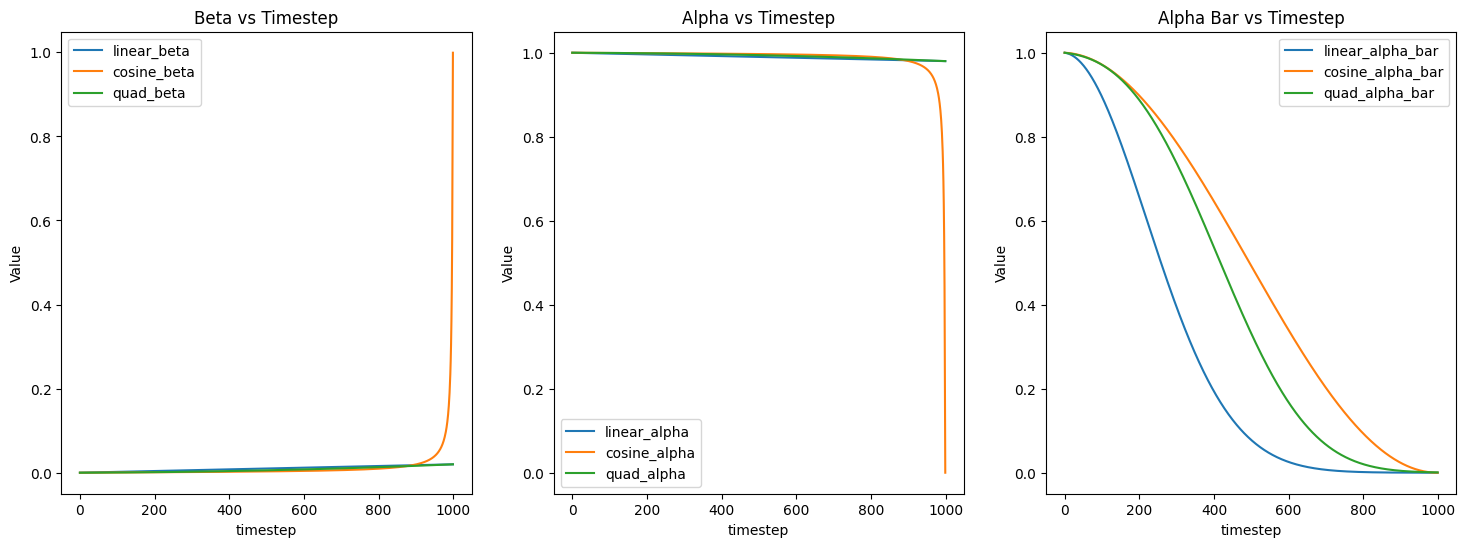

In [19]:
def create_noise_scheduler_dataframe(timesteps, beta_min, beta_max, modes):
    """
    Args:
        timesteps (int): Number of timesteps for the schedule.
        beta_min (float): Minimum beta value.
        beta_max (float): Maximum beta value.
        modes (list): List of scheduling modes to generate schedules for.

    Returns:
        pd.DataFrame: DataFrame containing beta, alpha, and alpha_bar schedules.
    """
    df = pd.DataFrame()
    df['timestep'] = np.arange(timesteps)

    for mode in modes:
        scheduler = NoiseScheduler(timesteps, beta_min, beta_max, mode)
        df[f'{mode}_beta'] = scheduler.get_beta_schedule()
        df[f'{mode}_alpha'] = scheduler.get_alpha_schedule()
        df[f'{mode}_alpha_bar'] = scheduler.get_alpha_bar_schedule()

    return df

def plot_scheduler_data(df, x_col, y_cols, titles):
    """
   Args:
        df (pd.DataFrame): DataFrame containing the scheduler data.
        x_col (str): Column name for the x-axis.
        y_cols (list of list): Lists of column names for the y-axis for each subplot.
        titles (list): Titles for each subplot.
    """
    plt.figure(figsize=(18, 6))

    for i, (y_col, title) in enumerate(zip(y_cols, titles), 1):
        plt.subplot(1, len(y_cols), i)
        for col in y_col:
            plt.plot(df[x_col], df[col], label=col)
        plt.xlabel(x_col)
        plt.ylabel('Value')
        plt.title(title)
        plt.legend()


def visualize_noise_schedulers():
    modes = ['linear', 'cosine', 'quad']
    noise_df = create_noise_scheduler_dataframe(timesteps=1000, beta_min=0.0001, beta_max=0.02, modes=modes)

    y_cols = [
        [f'{mode}_beta' for mode in modes],
        [f'{mode}_alpha' for mode in modes],
        [f'{mode}_alpha_bar' for mode in modes]
    ]
    titles = ['Beta vs Timestep', 'Alpha vs Timestep', 'Alpha Bar vs Timestep']

    plot_scheduler_data(noise_df, 'timestep', y_cols, titles)
    plt.show()

visualize_noise_schedulers()

## Diffusion Model

### Functionalities


- ```def forward(self, mask, conditioned_image, *args, **kwargs)```

<p style="text-align: center;">
  <img src="./images/train_algo.png" style="display: block; margin: auto;" width="400"/>
</p>

- ```def sample(self, conditioned_image)```

<p style="text-align: center;">
  <img src="./images/sample_algo.png" style="display: block; margin: auto;" width="400"/>
</p>

- ```def calculate_xt_from_x0(self, x_0, t, noise)```

$$
\begin{aligned}
\mathbf{x}_t &= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}
\end{aligned}
$$

- ```def calculate_x0_from_xt(self, x_t, t, noise)```
$$
\mathbf{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_t)
$$

- ```def estimate_mean(self, predicted_noise, x_t, t)```

$$
\begin{aligned}
\mu_\theta(\mathbf{x}_t, t) &= \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(\mathbf{x}_t, \; t) \Big)
\end{aligned}
$$

- ```def estimate_variance(self, t)```:

$$
\begin{aligned}
    \Sigma_\theta(\mathbf{x}_t, t) = \sigma^2_t \cdot \mathbf{I} =
    \begin{cases}
        \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t \;\; \text{or} \;\; \beta_t & \text{(Ho et al., 2020)} \\[2.5ex]
        \exp(\mathbf{v} \log \beta_t + (1-\mathbf{v}) \log \tilde{\beta}_t) & \text{(Nichol \& Dhariwal, 2021)}
    \end{cases}
\end{aligned}
$$

- ```def reverse_one_step(self, mask, t, conditioned_image)```

$$
\begin{aligned}
Calculates \;\; p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)
\end{aligned}
$$
$$
\begin{aligned}
\mathbf{x}_{t-1} &= \mathcal{N}(\mathbf{x}_{t-1}; \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(\mathbf{x}_t, t) \Big), \Sigma_\theta(\mathbf{x}_t, t))
\end{aligned}
$$

- ```def _setup_diffusion_tensors(self, betas, alphas, alpha_bars, alpha_bars_prev)```

In [20]:
from unet_util import normalize_to_neg_one_to_one, unnormalize_to_zero_to_one, default, identity, ModelPrediction

class Diffusion(nn.Module):
    """
    A denoising probabilistic Gaussian diffusion model (DDPM).

    Attributes:
        model (nn.Module): Neural network model for generating predictions.
        image_channels (int): Number of input image channels.
        mask_channels (int): Number of mask channels.
        image_size (int): Size of the image.
        device (torch.device): Device to run the model (CPU or GPU).
        num_timesteps (int): Number of timesteps for the diffusion process.
        Various other attributes for the diffusion process.
    """

    def __init__(self, model, device=device, timesteps=1000, noise_schedule='cosine'):
        """
        Initialize the Diffusion model.

        Args:
            model (nn.Module): Neural network model for generating predictions.
            device (torch.device): Device to run the model (CPU or GPU).
            timesteps (int): Number of timesteps for the diffusion process.
            noise_schedule (str): Type of noise scheduling ('linear', 'cosine', etc.).
        """
        super().__init__()
        self.model = model
        self.image_channels = model.image_channels
        self.mask_channels = model.mask_channels
        self.image_size = model.image_size
        self.device = device
        self._setup_diffusion_parameters(timesteps, noise_schedule)

    def _setup_diffusion_parameters(self, timesteps, noise_schedule):
        """
        Setup the diffusion process parameters.

        Args:
            timesteps (int): Number of timesteps for the diffusion process.
            noise_schedule (str): Type of noise scheduling.
        """
        noise_scheduler = NoiseScheduler(timesteps, mode=noise_schedule)
        betas = torch.tensor(noise_scheduler.get_beta_schedule())
        alphas = torch.tensor(noise_scheduler.get_alpha_schedule())
        alpha_bars = torch.tensor(noise_scheduler.get_alpha_bar_schedule())
        alpha_bars_prev = torch.tensor(noise_scheduler.get_alphas_bar_previous_schedule())

        self.num_timesteps = betas.shape[0]
        self._setup_diffusion_tensors(betas, alphas, alpha_bars, alpha_bars_prev)

    def _setup_diffusion_tensors(self, betas, alphas, alpha_bars, alpha_bars_prev):
        """
        Setup and convert diffusion tensors to the correct type and device, and register them as buffers.

        Args:
            betas, alphas, alpha_bars, alpha_bars_prev: Tensors for diffusion.
        """
        #       register a buffer for the following parameters for later use ( pts):
        #       beta(t), log(beta(t)), alpha_bar(t), alpha_bar(t-1), sqrt(alpha_bar(t)), sqrt(1 - alpha_bar(t)),
        #       1 / sqrt(alpha(t)), 1 / sqrt(alpha_bar(t)), beta(t) / sqrt(1 - alpha_bar(t)), beta_tilda(t), log(beta_tilda(t)).

        beta_tilda = betas * (1. - alpha_bars_prev) / (1. - alpha_bars)
        self.register_buffer('betas', betas.float())

        self.register_buffer('alpha_bars', alpha_bars.float())
        self.register_buffer('alpha_bars_prev', alpha_bars_prev.float())
        self.register_buffer('sqrt_alpha_bars', torch.sqrt(alpha_bars).float())
        self.register_buffer('sqrt_one_minus_alpha_bars', torch.sqrt(1. - alpha_bars).float())
        self.register_buffer('sqrt_inverse_alpha_bars', torch.sqrt(1. / alpha_bars).float())

        self.register_buffer('sqrt_inverse_alphas', torch.sqrt(1. / alphas).float())
        self.register_buffer('estimated_mean_noise_coefficient', (betas / torch.sqrt(1. - alpha_bars)).float())

        self.register_buffer('estimated_log_variance_beta_tilda', torch.log(beta_tilda.clamp(min=1e-20)).float())
        self.register_buffer('estimated_log_variance_beta', torch.log(betas).float())

    @device_grad_decorator(device=device, no_grad=True)
    def batch_select_time_indices(self, tensor, indices):
        """
        Args:
            tensor (torch.Tensor): The input tensor from which elements are to be extracted.
            indices (torch.Tensor): The tensor containing indices at which to extract elements.
        Returns:
            torch.Tensor: The reshaped tensor after extraction with shape [batch_size, 1, 1, 1]
        """
        return tensor.gather(dim=-1, index=indices).reshape(indices.shape[0], 1, 1, 1)

    @device_grad_decorator(device=device, no_grad=True)
    def calculate_x0_from_xt(self, x_t, t, noise):
        """
        Predict the start image from noise.

        Args:
            x_t (tensor): The noisy image at timestep t.
            t (int): The current timestep.
            noise (tensor): The noise tensor.

        Returns:
            The predicted start image at t=0.
        """
        sqrt_inverse_alpha_bars = self.batch_select_time_indices(self.sqrt_inverse_alpha_bars, t)
        sqrt_one_minus_alpha_bar_t = self.batch_select_time_indices(self.sqrt_one_minus_alpha_bars, t)
        return (x_t - sqrt_one_minus_alpha_bar_t * noise) * sqrt_inverse_alpha_bars

    @device_grad_decorator(device=device, no_grad=True)
    def estimate_mean(self, predicted_noise, x_t, t):
        sqrt_inverse_alpha = self.batch_select_time_indices(self.sqrt_inverse_alphas, t)
        noise_coefficient = self.batch_select_time_indices(self.estimated_mean_noise_coefficient, t)
        estimated_mean = sqrt_inverse_alpha * (x_t - noise_coefficient * predicted_noise)
        return estimated_mean

    @device_grad_decorator(device=device, no_grad=True)
    def estimate_variance(self, t):
        estimated_log_variance_beta_tilda = self.batch_select_time_indices(self.estimated_log_variance_beta_tilda, t)
        estimated_log_variance_beta = self.batch_select_time_indices(self.estimated_log_variance_beta, t)
        return estimated_log_variance_beta_tilda, estimated_log_variance_beta

    @device_grad_decorator(device=device, no_grad=True)
    def reverse_one_step(self, noisy_mask, t, conditioned_image):
        """
        Sample from the model.
        Args:
            mask (tensor): The input tensor.
            t (int): The current timestep.
            conditioned_image (tensor): Conditioning tensor.
        Returns:
            The predicted mask and the start mask.
        """
        batched_times = torch.full((noisy_mask.shape[0],), t, dtype=torch.long, device=self.device)

        predicted_noise = self.model(noisy_mask, batched_times, conditioned_image)
        model_mean = self.estimate_mean(predicted_noise, noisy_mask, batched_times)
        log_var_beta_tilda, log_var_beta = self.estimate_variance(batched_times)

        noise = torch.randn_like(noisy_mask) if t > 0 else torch.zeros_like(noisy_mask)  # no noise if t == 0
        sigma = (0.5 * log_var_beta).exp()
        predicted_previous_mask = model_mean + sigma * noise
        return predicted_previous_mask

    @device_grad_decorator(device=device, no_grad=True)
    def sample(self, conditioned_image):
        """
        Generate a sample based on conditioning image.

        Args:
            conditioned_image (tensor): Conditioning images tensor with the shape of [batch_size, channels, height, width].
        Returns:
            Generated masks tensor.
        """
        noisy_mask = torch.randn(
            (conditioned_image.shape[0], self.mask_channels, self.image_size, self.image_size),
            device=self.device,
        )

        for t in tqdm(reversed(range(self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            noisy_mask = self.reverse_one_step(noisy_mask, t, conditioned_image)

        denoised_mask = unnormalize_to_zero_to_one(noisy_mask)
        return denoised_mask

    @device_grad_decorator(device=device)
    def calculate_xt_from_x0(self, x_0, t, noise):
        """
        Args:
            x_0 (tensor): The start image.
            t (int): The current timestep.
            noise (tensor): Optional noise tensor.

        Returns:
            Sampled image tensor.
        """
        first_term = self.batch_select_time_indices(self.sqrt_alpha_bars, t) * x_0
        second_term = self.batch_select_time_indices(self.sqrt_one_minus_alpha_bars, t) * noise
        return first_term + second_term

    @device_grad_decorator(device=device)
    def forward(self, mask, conditioned_image, *args, **kwargs):
        """
        Forward pass through the Diffusion model.

        Args:
            img (tensor): Input image tensor.
            conditioned_image (tensor): Conditioning image tensor.
            args: Additional arguments.
            kwargs: Keyword arguments.

        Returns:
            The loss for the model.
        """
        mask, conditioned_image = mask.to(self.device), conditioned_image.to(self.device)
        t = torch.randint(0, self.num_timesteps, [mask.shape[0]], device=self.device).long()

        mask = normalize_to_neg_one_to_one(mask)
        noise = torch.randn(mask.shape, device=self.device)

        x_t = self.calculate_xt_from_x0(mask, t, noise)
        noise_hat = self.model(x_t, t, conditioned_image)

        loss = F.mse_loss(noise_hat.reshape(mask.shape[0], -1), noise.reshape(mask.shape[0], -1))
        return loss

# Dataset & DataLoader

## Splitting To Train/Test/Val

In [21]:
def split_dataset(mri_df, x_col, y_col, stratify_col, test_size=TEST_SIZE, random_state=RANDOM_SEED):
    """
    Splits the dataset into training and testing sets.

    Args:
        mri_df (pd.DataFrame): The dataframe containing MRI data.
        x_col (str): The column name for the input features.
        y_col (str): The column name for the target variable.
        stratify_col (str): The column name for stratification.
        test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to TEST_SIZE.
        random_state (int, optional): The random seed for reproducibility. Defaults to RANDOM_SEED.

    Returns:
        tuple: A tuple containing the training and testing dataframes (train_df, test_df).
    """
    X_train, X_test, y_train, y_test = train_test_split(
        mri_df[[x_col]],
        mri_df[[y_col, 'has_cancer']],
        test_size=test_size,
        random_state=random_state,
        stratify=mri_df[stratify_col],
    )

    train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
    return train_df, test_df

In [22]:
train_df, test_df = split_dataset(
    mri_df,
    'image_path',
    'mask_path',
    'has_cancer',
)

print(f'train df count: {len(train_df)}')
print(f'test df count: {len(test_df)}')

train df count: 3536
test df count: 393


## Transformations

In [23]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_HEIGHT, IMAGE_HEIGHT), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_HEIGHT, IMAGE_HEIGHT), interpolation=transforms.InterpolationMode.NEAREST),
])

joint_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ],
    p=1,
)

## Create Torch Dataset

In [24]:
class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform, mask_transform, joint_transform):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.get_unprocessed_image(idx)
        mask = self.get_unprocessed_mask(idx)
        label = int(self.dataframe['has_cancer'][idx])
        transformed = self.joint_transform(image=image, mask=mask)

        image = transformed['image']
        mask = transformed['mask']

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask, torch.tensor(label).int()

    def get_unprocessed_mask(self, idx):
        mask_path = self.dataframe['mask_path'][idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        return mask

    def get_unprocessed_image(self, idx):
        image_path = self.dataframe['image_path'][idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

train_dataset = BrainMRIDataset(train_df, image_transform, mask_transform, joint_transform)
test_dataset = BrainMRIDataset(test_df, image_transform, mask_transform, joint_transform)

train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

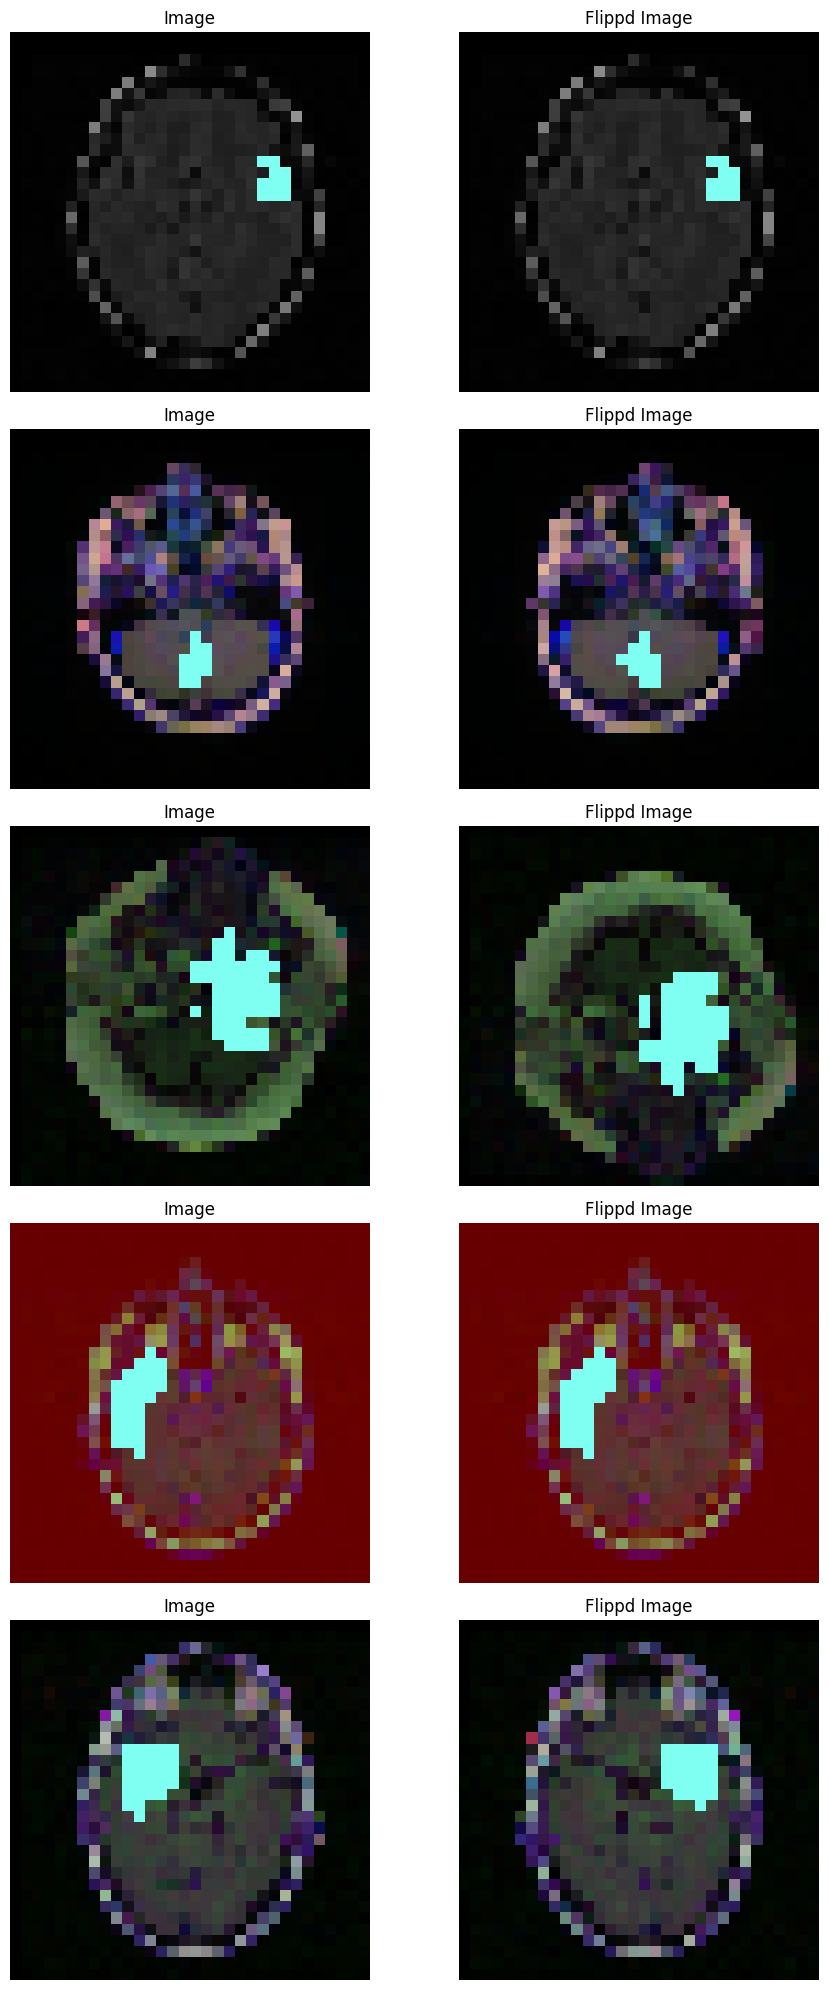

In [25]:
def test_joint_transform(
    dataset_class=BrainMRIDataset,
    df=train_df,
    joint_transform=joint_transform,
    mock_joint_transform=A.Compose([], p=1),
    image_transform=image_transform,
    mask_transform=mask_transform,
    num_samples=5
):
    partial_class = partial(dataset_class, dataframe=df ,image_transform=image_transform, mask_transform=mask_transform)
    org_dataset = partial_class(joint_transform=mock_joint_transform)
    flipped_dataset = partial_class(joint_transform=joint_transform)
    random_indices = df[df['has_cancer'] == 1][['has_cancer']].sample(num_samples).reset_index()['index'].tolist()
    plt.figure(figsize=(10, 4 * num_samples))

    for i, index in enumerate(random_indices):
        org_image, org_mask, _ = org_dataset[index]
        org_image, org_mask = org_image.permute(1, 2, 0).numpy(), org_mask.permute(1, 2, 0).squeeze(2).numpy()

        flipped_image, flipped_mask, _ = flipped_dataset[index]
        flipped_image, flipped_mask = flipped_image.permute(1, 2, 0).numpy(), flipped_mask.permute(1, 2, 0).squeeze(2).numpy()
        org_image[org_mask==1] = (0, 1, .9)
        flipped_image[flipped_mask==1] = (0, 1, .9)
        org_image = unnormalize_to_zero_to_one(org_image)
        flipped_image = unnormalize_to_zero_to_one(flipped_image)
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(org_image)
        plt.title(f"Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(flipped_image)
        plt.title(f"Flippd Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

test_joint_transform()

# Training

## Training Configuration

In [26]:
# Initialize the U-Net model
unet = Unet(
    image_size=IMAGE_HEIGHT,
    num_layers=2,
    skip_connect_image_feature_maps=False
).to(device)

# Initialize the diffusion model
diffusion = Diffusion(
    model=unet,
    device=device,
    timesteps=TIMESTEPS,
    noise_schedule=NOISE_SCHEDULE
).to(device)

# Display model parameter count
num_parameters = sum(p.numel() for p in unet.parameters())
print(f'Number of parameters: {num_parameters}')

Number of parameters: 405041


In [27]:
# Configure optimizer and scheduler
optimizer = torch.optim.Adam(diffusion.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=REDUCE_LR_FACTOR,
    patience=REDUCE_LR_PATIENCE,
    verbose=True
)

In [28]:
def plot_prediction(axs, index, dataset, prediction):
    """
    Plot an MRI image, its corresponding mask, and the predicted mask.

    Args:
        axs: List of matplotlib Axes objects for plotting.
        index: Index of the sample in the dataset.
        dataset: The dataset containing the images and masks.
        prediction: The predicted mask (Tensor).
    """
    # Retrieve the unprocessed image and corresponding label
    img = dataset.get_unprocessed_image(index)
    _, mask, label = dataset[index]

    # Set up the MRI image
    label = int(label)
    status = 'Cancerous' if label == 1 else 'Non-cancerous'
    axs[0].imshow(img)
    axs[0].set_title(f'A {status} MRI')
    axs[0].axis('off')

    # Plot the ground truth mask
    mask = mask.permute(1, 2, 0).numpy()
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Mask")
    axs[1].axis('off')

    # Plot the predicted mask
    prediction = prediction.detach().cpu().permute(1, 2, 0).numpy()
    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title("Mask Prediction")
    axs[2].axis('off')


@device_grad_decorator(no_grad=True)
def sample_and_visualize(diffusion, dataset, num_samples, device=device):
    """
    Sample and visualize predictions for a subset of the dataset.

    Args:
        diffusion: The diffusion model for generating samples.
        dataset: The dataset containing images and masks.
        num_samples: Number of samples to visualize.
        device: The device to run computations on.
    """
    # Randomly select indices from the dataset
    sampled_indices = np.random.choice(len(dataset), size=num_samples, replace=False)
    
    # Load the sampled images and move them to the specified device
    sampled_images = torch.stack([dataset[i][0] for i in sampled_indices]).to(device)
    
    # Generate predictions using the diffusion model
    predictions = diffusion.sample(sampled_images)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    # Ensure axs is always iterable (even for one sample)
    if num_samples == 1:
        axs = [axs]
    
    # Plot each sample's MRI image, mask, and prediction
    for i, sample_idx in enumerate(sampled_indices):
        plot_prediction(axs[i], sample_idx, dataset, predictions[i])
    
    # Adjust layout and show the visualization
    fig.tight_layout()
    plt.show()


## Training & Evaluation Loops

In [29]:
def train_one_epoch(diffusion, train_dataloader, optimizer, scheduler, device=device):
    """
    Train the diffusion model for one epoch.

    Args:
        diffusion: The diffusion model.
        train_dataloader: DataLoader for the training dataset.
        optimizer: Optimizer for updating model parameters.
        scheduler: Learning rate scheduler.
        device: Device to run computations on.

    Returns:
        train_mean_loss: Average training loss for the epoch.
    """
    diffusion.train()
    total_loss = 0.0

    for img, mask, label in tqdm(train_dataloader, desc="Training", leave=False):
        # Move data to the appropriate device
        img, mask = img.to(device), mask.to(device)

        # Forward pass and compute loss
        optimizer.zero_grad()
        loss = diffusion(mask, img)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

    # Compute average loss and update scheduler
    train_mean_loss = total_loss / len(train_dataloader)
    scheduler.step(train_mean_loss)

    return train_mean_loss


@device_grad_decorator(no_grad=True)
def test_one_epoch(diffusion, test_dataloader, device=device):
    """
    Evaluate the diffusion model for one epoch.

    Args:
        diffusion: The diffusion model.
        test_dataloader: DataLoader for the test dataset.
        device: Device to run computations on.

    Returns:
        test_mean_loss: Average test loss for the epoch.
    """
    diffusion.eval()
    total_loss = 0.0

    for img, mask, label in tqdm(test_dataloader, desc="Testing", leave=False):
        # Move data to the appropriate device
        img, mask = img.to(device), mask.to(device)

        # Forward pass and compute loss
        loss = diffusion(mask, img)

        # Accumulate loss
        total_loss += loss.item()

    # Compute average loss
    test_mean_loss = total_loss / len(test_dataloader)

    return test_mean_loss

def save_model(diffusion, old_best_epoch, new_best_epoch, path_template=MODEL_SAVE_PATH_TEMPLATE):
    """
    Save the current best model, removing the previous best model file.

    Args:
        diffusion: The diffusion model.
        old_best_epoch: The epoch number of the previous best model.
        new_best_epoch: The epoch number of the current best model.
        path_template: Template for the model file path.
    """
    # Remove old best model if it exists
    old_model_path = path_template.format(old_best_epoch)
    if os.path.exists(old_model_path):
        os.remove(old_model_path)

    # Save the new best model
    new_model_path = path_template.format(new_best_epoch)
    torch.save(diffusion.state_dict(), new_model_path)


In [30]:
def train_and_evaluate(
    diffusion,
    train_dataloader,
    test_dataloader,
    optimizer,
    scheduler,
    num_epochs,
    model_save_path_template,
    visualization_interval=VISUALIZATION_SAMPLE_INTERVAL,
    visualization_num_samples=VISUALIZATION_NUM_SAMPLES,
    device=device,
):
    """
    Train and evaluate the diffusion model.

    Args:
        diffusion: The diffusion model.
        train_dataloader: DataLoader for the training dataset.
        test_dataloader: DataLoader for the test dataset.
        optimizer: Optimizer for training.
        scheduler: Learning rate scheduler.
        num_epochs: Number of epochs to train for.
        model_save_path_template: Template string for saving model checkpoints.
        visualization_interval: Interval for visualizing results.
        visualization_num_samples: Number of samples to visualize.

    Returns:
        train_losses: List of average training losses for each epoch.
        test_losses: List of average test losses for each epoch.
    """
    best_test_loss = float('inf')
    best_test_loss_epoch = -1
    train_losses = []
    test_losses = []

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("-" * 30)

        # Train for one epoch
        train_loss = train_one_epoch(diffusion, train_dataloader, optimizer, scheduler)
        train_losses.append(train_loss)

        # Evaluate for one epoch
        test_loss = test_one_epoch(diffusion, test_dataloader)
        test_losses.append(test_loss)

        # Save model if it's the best test loss
        if test_loss < best_test_loss:
            save_model(diffusion, best_test_loss_epoch, epoch, model_save_path_template)
            best_test_loss = test_loss
            best_test_loss_epoch = epoch

        # Log progress
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Best Test Loss: {best_test_loss:.4f} (Epoch {best_test_loss_epoch})")

        # Visualization
        if epoch % visualization_interval == 0 or epoch == num_epochs:
            sample_and_visualize(
                diffusion,
                test_dataloader.dataset,
                num_samples=visualization_num_samples,
                device=device,
            )

    print(f"\nTraining complete. Best Test Loss: {best_test_loss:.4f} at Epoch {best_test_loss_epoch}.")
    return train_losses, test_losses, best_test_loss_epoch

In [ ]:
# Train and evaluate the model
train_losses, test_losses, best_epoch = train_and_evaluate(
    diffusion=diffusion,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    model_save_path_template=MODEL_SAVE_PATH_TEMPLATE,
)

# Testing

## Visualize Losses

In [35]:
def plot_losses(train_losses, test_losses):
    """
    Plot the training and test losses over epochs.

    Args:
        train_losses: List of training losses for each epoch.
        test_losses: List of test losses for each epoch.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)  # Epochs start at 1 for better clarity

    plt.plot(epochs, train_losses, label='Train Loss', linewidth=2)
    plt.plot(epochs, test_losses, label='Test Loss', linewidth=2)

    plt.title('Training vs Test Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.yscale('log')  # Logarithmic scale for better visualization
    plt.legend(fontsize=12)
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()


In [ ]:
plot_losses(train_losses, test_losses)

## Sample Predictions

In [34]:
def load_best_model(diffusion, model_save_path_template, best_epoch, device=device):
    """
    Load the best saved diffusion model from the specified epoch.

    Args:
        diffusion: The diffusion model instance.
        model_save_path_template: Template for the model file path.
        best_epoch: The epoch number of the best model.
        device: Device to run computations on.

    Returns:
        diffusion: The diffusion model with loaded weights.
    """
    best_model_path = model_save_path_template.format(str(int(best_epoch)))
    diffusion.load_state_dict(
        torch.load(
            best_model_path,
            map_location=device,
        ),
        strict=False,
    )
    diffusion.eval()
    print(f"Best model from epoch {best_epoch} loaded successfully.")
    return diffusion

def visualize_best_model_predictions(diffusion, dataset, num_samples, device=device):
    """
    Visualize predictions of the best diffusion model on a subset of the dataset.

    Args:
        diffusion: The best diffusion model with loaded weights.
        dataset: The dataset containing images and masks.
        num_samples: Number of samples to visualize.
        device: Device to run computations on.
    """
    print("\nVisualizing predictions from the best model...")
    sample_and_visualize(diffusion, dataset, num_samples, device=device)

In [ ]:
best_diffusion_model = load_best_model(diffusion, MODEL_SAVE_PATH_TEMPLATE, best_epoch)
visualize_best_model_predictions(best_diffusion_model, test_dataloader.dataset, num_samples=5)